# Random Forest

In [49]:
#Insert the parameter ranges we want to evaluate
#For the random forest, we can look at the performance of the classifier 
#by searching for the random forest with the optimal values for the following parameters:
#Maximum depth of each tree (max_depth),
#Number of trees in the forest (n_estimators)
#Number of variables to consider when looking for the best split when growing trees (max_features)
hyper_parameters_random_forest = [{'max_features':[max(1,n_features * 5) for n_features in xrange(int(np.shape(X)[1]/5 + 1))],'n_estimators':[40,60,80],'max_depth':[4,6]}]

-2106.099 (+/-110.184) for {'max_features': 1, 'n_estimators': 40, 'max_depth': 4}
-2104.276 (+/-122.478) for {'max_features': 1, 'n_estimators': 60, 'max_depth': 4}
-2087.869 (+/-118.784) for {'max_features': 1, 'n_estimators': 80, 'max_depth': 4}
-2017.553 (+/-153.981) for {'max_features': 5, 'n_estimators': 40, 'max_depth': 4}
-2002.708 (+/-140.720) for {'max_features': 5, 'n_estimators': 60, 'max_depth': 4}
-1992.812 (+/-139.321) for {'max_features': 5, 'n_estimators': 80, 'max_depth': 4}
-2007.657 (+/-136.688) for {'max_features': 10, 'n_estimators': 40, 'max_depth': 4}
-2008.959 (+/-133.179) for {'max_features': 10, 'n_estimators': 60, 'max_depth': 4}
-2011.563 (+/-132.340) for {'max_features': 10, 'n_estimators': 80, 'max_depth': 4}
-2020.418 (+/-116.947) for {'max_features': 15, 'n_estimators': 40, 'max_depth': 4}
-2014.167 (+/-129.256) for {'max_features': 15, 'n_estimators': 60, 'max_depth': 4}
-2020.157 (+/-138.228) for {'max_features': 15, 'n_estimators': 80, 'max_depth': 4

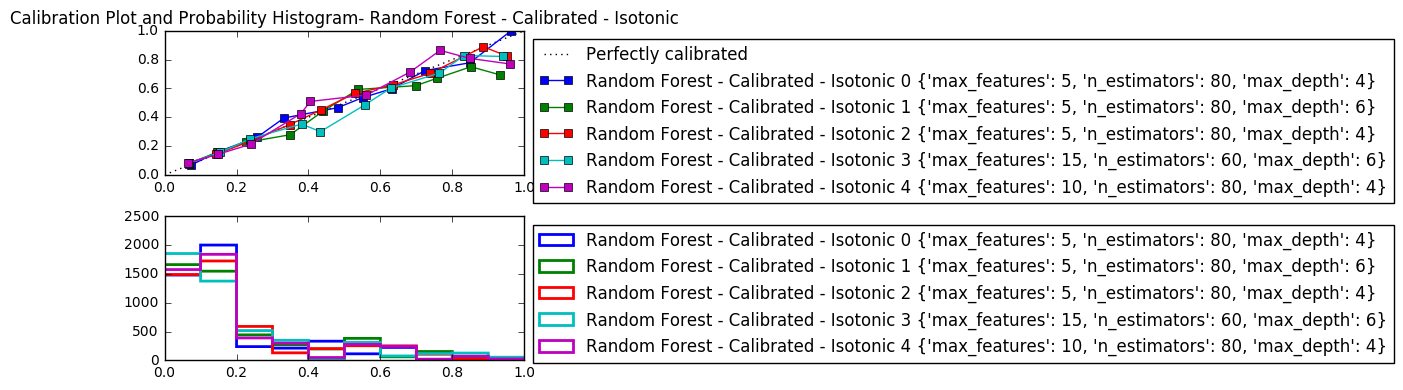

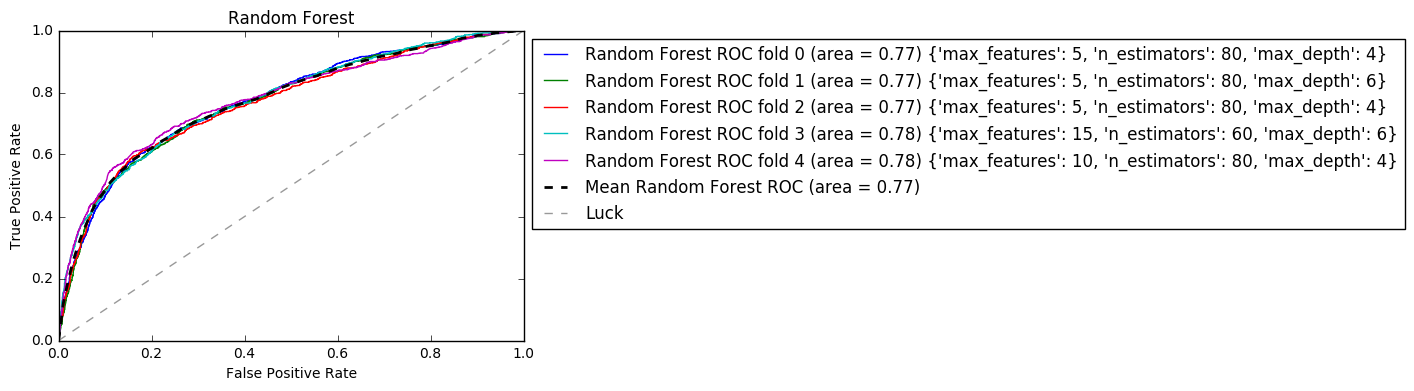

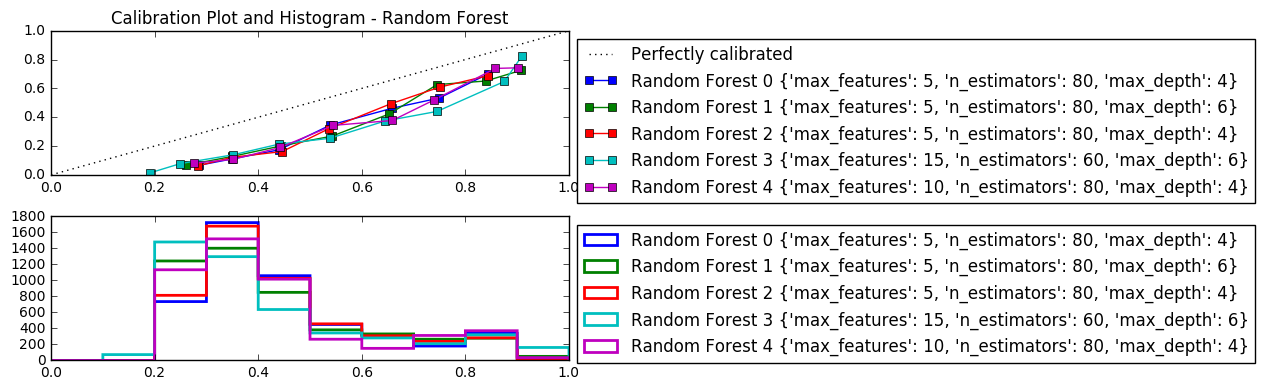

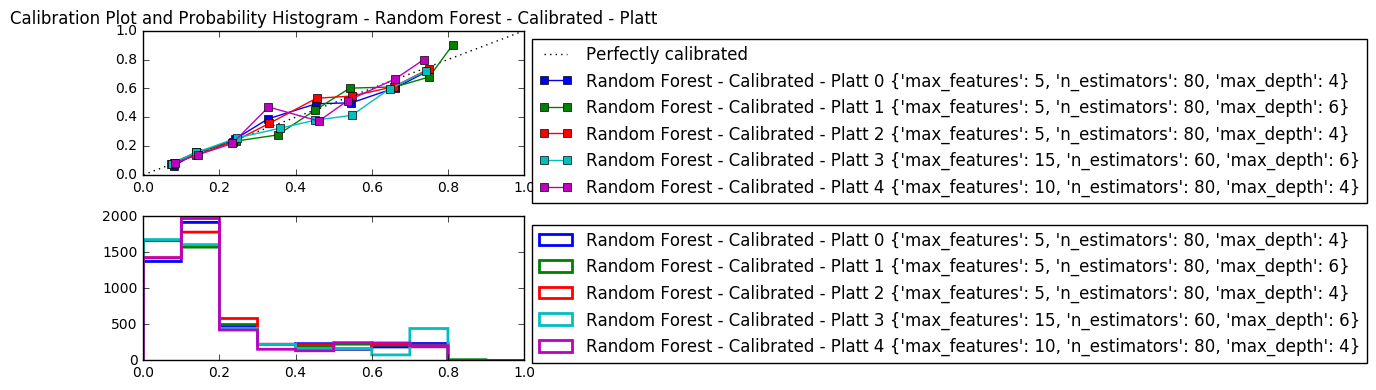

In [50]:
#Start cross validation and draw the ROC curves
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

#The first plot will display the Calibration Plot and Histogram
plt.figure(6)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])

#The first plot will display the Calibration Plot and Histogram for 
#probabilities calibrated with Platt's method
plt.figure(7)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])

#The first plot will display the Calibration Plot and Histogram for 
#probabilities calibrated with Isotonic regression
plt.figure(8)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])

for i, (train, validation) in enumerate(cv):
    classifier_random_forest = RandomForestClassifier(criterion = 'entropy',
                                                  min_samples_split = 1,min_samples_leaf = 1,
                                                  min_weight_fraction_leaf = 0, max_leaf_nodes = None, 
                                                  bootstrap = True, oob_score = True,n_jobs = -1,
                                                  random_state = 1,verbose = 0,warm_start = False,
                                                  class_weight = 'balanced')
    #Create an instance of the random search class
    grid = GridSearchCV(classifier_random_forest,hyper_parameters_random_forest,cv = 5, scoring = score_cost,refit = True)
    #Fit Random Forest
    grid.fit(X_train_validation[train],y_train_validation[train])
    max_score = 0
    for params, mean_score, scores in grid.grid_scores_:
        print('%0.3f (+/-%0.03f) for %r' % (mean_score, scores.std() * 2, params))
        if mean_score > max_score:
            max_score = mean_score
    print('Random Forest ',i,'best parameters','true values %0.03f' % (sum(y_train_validation[train])/len(y_train_validation[train])))
    print(grid.best_params_,'max score',max_score)
    
    #Calibrate probabilities with Platt's method. This is equivalent to fitting a logistic regression to 
    #true class values in the traning set using the uncalibrated predicted probabilities
    probas_train = grid.predict_proba(X_train_validation[train])[:,1]    
    lr.fit(probas_train.reshape( -1, 1 ),y_train_validation[train])    

    #Calibrate probabilities with isotonic regression. Isotonic regression fits a 
    #non-decreasing function to the data
    ir.fit(probas_train,y_train_validation[train])
    
    #Predict the test set in the current fold
    #Index 1 includes the probabilities of belonging to class '1' (delayed)
    probas_validation = grid.predict_proba(X_train_validation[validation])[:,1]
    #Calculate the calibrated probabilities with Platt's method    
    probas_calibrated_platt = lr.predict_proba(probas_validation.reshape( -1, 1 ))[:,1]
    #Calculate the calibrated probabilities with isotonic regression
    probas_calibrated_isotonic = ir.transform(probas_validation)     
    
    #Plot the calibration curves
    fraction_of_positives, mean_predicted_value = calibration_curve(y_train_validation[validation], probas_validation, n_bins=10)
    #Plot the calibration curves for calibrated probabilities platt
    fraction_of_positives_calibrated_platt, mean_predicted_value_calibrated_platt = calibration_curve(y_train_validation[validation], probas_calibrated_platt, n_bins=10)
    #Plot the calibration curves for calibrated probabilities isotonic
    fraction_of_positives_calibrated_isotonic, mean_predicted_value_calibrated_isotonic = calibration_curve(y_train_validation[validation], probas_calibrated_isotonic, n_bins=10)
            
    # Compute ROC curve and the area under the curve
    fpr, tpr, thresholds = roc_curve(y_train_validation[validation], probas_validation)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.figure(9)    
    plt.plot(fpr, tpr, lw=1, label='Random Forest ROC fold %d (area = %0.2f) %r' % (i, roc_auc,grid.best_params_))

    plt.figure(6)
    plt.subplot(211)
    plt.plot(mean_predicted_value,fraction_of_positives,"s-",label = 'Random Forest %d %r' % (i,grid.best_params_))
    plt.subplot(212)
    plt.hist(probas_validation,range=(0,1),bins= 10, label = "Random Forest %d %r" % (i,grid.best_params_),histtype = "step", lw = 2)

    plt.figure(7)    
    plt.subplot(211)
    plt.plot(mean_predicted_value_calibrated_platt,fraction_of_positives_calibrated_platt,"s-",label = 'Random Forest - Calibrated - Platt %d %r' % (i,grid.best_params_))
    plt.subplot(212)
    plt.hist(probas_calibrated_platt,range=(0,1),bins= 10, label = "Random Forest - Calibrated - Platt %d %r" % (i,grid.best_params_),histtype = "step", lw = 2)
    
    plt.figure(8)    
    plt.subplot(211)
    plt.plot(mean_predicted_value_calibrated_isotonic,fraction_of_positives_calibrated_isotonic,"s-",label = 'Random Forest - Calibrated - Isotonic %d %r' % (i,grid.best_params_))
    plt.subplot(212)
    plt.hist(probas_calibrated_isotonic,range=(0,1),bins= 10, label = "Random Forest - Calibrated - Isotonic %d %r" % (i,grid.best_params_),histtype = "step", lw = 2)
       
#Draw the mean ROC curve
plt.figure(9)    
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean Random Forest ROC (area = %0.2f)' % mean_auc, lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.title('Random Forest')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig('Mean Random Forest ROC')

plt.figure(6)
plt.subplot(211)
plt.title('Calibration Plot and Histogram - Random Forest')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Random Forest')

plt.figure(7)
plt.subplot(211)
plt.title('Calibration Plot and Probability Histogram - Random Forest - Calibrated - Platt')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Random Forest - Calibrated - Platt')

plt.figure(8)
plt.subplot(211)
plt.title('Calibration Plot and Probability Histogram- Random Forest - Calibrated - Isotonic')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Random Forest - Calibrated - Isotonic')

In [51]:
#We are going to use 5 features, 80 trees (n_estimators) and 4 as the max_tree depth.
classifier_random_forest = RandomForestClassifier(criterion = 'entropy',
                                              max_depth = 4, max_features = 5, n_estimators = 80,
                                              min_samples_split = 1,min_samples_leaf = 1,
                                              min_weight_fraction_leaf = 0, max_leaf_nodes = None, 
                                              bootstrap = True, oob_score = True,n_jobs = -1,
                                              random_state = 1,verbose = 0,warm_start = False,
                                              class_weight = 'balanced')

In [52]:
#Use the train and validation data to fit the model with the optimal parameter
classifier_random_forest.fit(X_train_validation,y_train_validation) 
#Get training probabilities for probability calibration
probabilities_train = classifier_random_forest.predict_proba(X_train_validation)[:,1]
#calibrate probabilities with isotonic regression
ir.fit(probabilities_train,y_train_validation)                          
#calibrate probabilities with platt's method
lr.fit(probabilities_train.reshape( -1, 1 ),y_train_validation) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
#Get the feature importances and names in dataframe
importance = pd.DataFrame(classifier_random_forest.feature_importances_,columns = ['Importance'],index = variable_names)
importance = importance.sort_values(by = 'Importance', axis = 0, ascending = False)
pd.DataFrame(importance).to_csv('importance_forest.csv',index = False)
print(importance[:10])

           Importance
PAY_0        0.336271
PAY_2        0.165169
PAY_3        0.113701
PAY_4        0.089588
PAY_6        0.051283
PAY_AMT1     0.044504
PAY_5        0.041278
LIMIT_BAL    0.034640
PAY_AMT2     0.023633
PAY_AMT4     0.022117


In [54]:
#Use the random forest model on the test set and get uncalibrated probabilities
probabilities_test = classifier_random_forest.predict_proba(X_test)[:,1]
#Use the cost sensitive threshold to predict the outcome
predictions_test_cost = [0 if x < threshold_cost else 1 for x in probabilities_test]
#Use the 50% threshold to predict the outcome
predictions_test_50 = [0 if x < threshold_05 else 1 for x in probabilities_test]
#Calibrate the probabilities by isotonic regression 
probas_calibrated_isotonic = ir.transform(probabilities_test)
#Use the cost sensitive threshold to predict the outcome
predictions_test_calibrated_isotonic_cost = [0 if x < threshold_cost else 1 for x in probas_calibrated_isotonic]
#Use the 50% threshold to predict the outcome
predictions_test_calibrated_isotonic_50 = [0 if x < threshold_05 else 1 for x in probas_calibrated_isotonic]
#Calibrate the probabilities by isotonic regression 
probas_calibrated_platt = lr.predict_proba(probabilities_test.reshape( -1, 1 ))[:,1]
#Use the cost sensitive threshold to predict the outcome
predictions_test_calibrated_platts_cost = [0 if x < threshold_cost else 1 for x in probas_calibrated_platt]
#Use the 50% threshold to predict the outcome
predictions_test_calibrated_platts_50 = [0 if x < threshold_05 else 1 for x in probas_calibrated_platt]

In [55]:
#Print the expected cost and the classification report for uncalibrated probabilities, 
#isotonic calibrated probabilities and platts calibrated probabilities
#with cost-sensitive threshold and 50% threshold
print('Uncalibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_cost))
print(classification_report(y_test, predictions_test_cost,target_names = ['Pay','Default']))
print('Uncalibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_50))
print(classification_report(y_test, predictions_test_50,target_names = ['Pay','Default']))
print('Isotonic calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_isotonic_cost))
print(classification_report(y_test, predictions_test_calibrated_isotonic_cost,target_names = ['Pay','Default']))
print('Isotonic calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_isotonic_50))
print(classification_report(y_test, predictions_test_calibrated_isotonic_50,target_names = ['Pay','Default']))
print('Platts calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_platts_cost))
print(classification_report(y_test, predictions_test_calibrated_platts_cost,target_names = ['Pay','Default']))
print('Platts calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_platts_50))
print(classification_report(y_test, predictions_test_calibrated_platts_50,target_names = ['Pay','Default']))
print('Dummy classifier: %i ' % expected_cost(y_test, clf_predictions))
print(classification_report(y_test, clf_predictions,target_names = ['Pay','Default']))

Uncalibrated probabilities, cost sensitive threshold: 3885 
             precision    recall  f1-score   support

        Pay       0.00      0.00      0.00      4663
    Default       0.22      1.00      0.36      1337

avg / total       0.05      0.22      0.08      6000

Uncalibrated probabilities, 50pct threshold: 2042 
             precision    recall  f1-score   support

        Pay       0.87      0.84      0.85      4663
    Default       0.50      0.58      0.54      1337

avg / total       0.79      0.78      0.78      6000

Isotonic calibrated probabilities, cost sensitive threshold: 2073 
             precision    recall  f1-score   support

        Pay       0.87      0.86      0.86      4663
    Default       0.52      0.55      0.53      1337

avg / total       0.79      0.79      0.79      6000

Isotonic calibrated probabilities, 50pct threshold: 2435 
             precision    recall  f1-score   support

        Pay       0.83      0.95      0.89      4663
    Default 

The smallest cost is given by using uncalibrated probabilities and the 50% threshold. But the calibration plots suggest that the probabilities adjusted with the Platt's method are closer to observed probabilities. The dummy classifier which predicts 'payment' for all instances (assigns the majority class) has the highest cost.

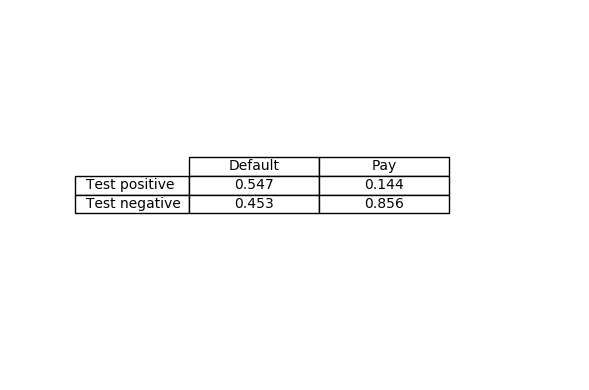

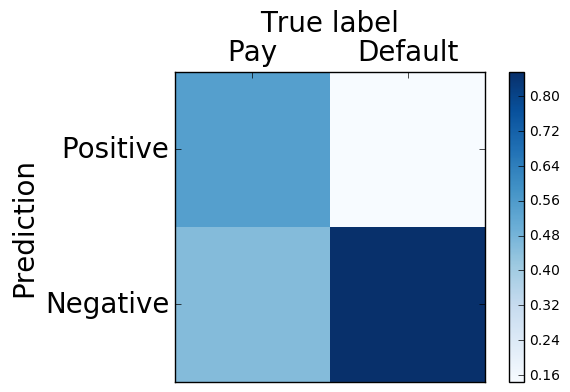

In [56]:
#Plot the confusion matrix 
cm = confusion_matrix_custom(y_test,predictions_test_calibrated_isotonic_cost)
cm = np.round(cm, decimals = 3)
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=cm,
          rowLabels=['Test positive','Test negative'],
          colLabels=['Default','Pay'],
          cellLoc='center',colWidths=[0.25, 0.25],
          loc='center')
plt.tight_layout()

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues, interpolation='none')
fig.colorbar(im)
locs = np.arange(len(np.unique(y_test)))
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks(locs + 0.5)
ax.xaxis.set(ticks=locs, ticklabels=['Pay','Default'])
ax.yaxis.set_ticks(locs + 0.5)
ax.yaxis.set(ticks=locs, ticklabels=['Positive','Negative'])
plt.xlabel('True label', fontsize=20)
plt.ylabel('Prediction', fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
ax.grid(False) 